In [1]:
pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.4 MB/s eta 0:00:00


In [2]:
pip install scikeras

In [56]:
import pandas as pd
import numpy as np
from scipy import stats
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sentiAnalyser = SentimentIntensityAnalyzer()
import shap
shap.initjs()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split,KFold

import keras
from keras import models
from keras import layers
from keras.models import Sequential, clone_model
from keras.layers import Dense,Dropout,Input
from scikeras.wrappers import KerasClassifier


from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import F1Score, AUC
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2


import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [4]:
true_df = pd.read_csv("/content/True.csv")
fake_df = pd.read_csv("/content/Fake.csv")
true_df["label"]="true"
fake_df["label"]="fake"

true_df = true_df.drop_duplicates()
fake_df = fake_df.drop_duplicates()

true_df["combined_text"]=true_df["title"]+true_df["text"]
fake_df["combined_text"]=fake_df["title"]+fake_df["text"]


In [5]:
merge_frames = [true_df,fake_df]
df = pd.concat(merge_frames)
df = df.sample(frac=1)
df = df.drop_duplicates()  #drop duplicated data

df=df.drop(['date'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 10142 to 23087
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          44689 non-null  object
 1   text           44689 non-null  object
 2   subject        44689 non-null  object
 3   label          44689 non-null  object
 4   combined_text  44689 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


Clean data

In [6]:
df['url']= [re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',x) for x in df.combined_text]
df['url_count']=df['url'].str.len()
df = df.drop('url',axis=1)

In [7]:
df['pronoun']=[re.findall(r'\bI\b|\bme\b|\bMy\b|\bmy\b|\byou\b|\bYou\b|\bhe\b|\bHe\b|\bhim\b|\bshe\b|\bShe\b|\bher\b|\bit\b|\bIt\b|\bwe\b|\bWe\b|\bus\b|\bthey\b|\bThey\b|\bthem\b',x) for x in df.combined_text]
df['pronoun_counts']=df['pronoun'].str.len()
df=df.drop('pronoun',axis=1)

In [8]:
df['spe_char_count']=df['combined_text'].str.count('@!?')

In [9]:
def remove_single_chars(text):
    return re.sub(r'\b(?![uU])[a-zA-Z]\b', '', text)

df['cleaned_text']=df['combined_text'].apply(remove_single_chars)

In [10]:
# Function to calculate sentiment score
def cal_sentiment(text):
    score = sentiAnalyser.polarity_scores(text)
    compound_score = score['compound']
    return compound_score

# Parallelize the sentiment calculation
def parallel_sentiment_analysis(df, num_jobs=4):
    # Parallelizing the apply function
    return Parallel(n_jobs=num_jobs)(delayed(cal_sentiment)(text) for text in df['cleaned_text'])

# Use the parallelized function
df['sentiment_score'] = parallel_sentiment_analysis(df)

In [11]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return " ".join(lemmatizer.lemmatize(w.lower()) for w in  nltk.wordpunct_tokenize(text))

df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)

# Exploratory data analysis

In [24]:
fake_df=fake_df.drop(fake_df.index,inplace=True)
fake_df = df[df['label']=='fake']

In [28]:
true_df = true_df.drop(true_df.index,inplace=True)
true_df = df[df['label']=='true']

## Fake news dataset

In [47]:
print(fake_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 23478 entries, 9798 to 23087
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            23478 non-null  object 
 1   text             23478 non-null  object 
 2   subject          23478 non-null  object 
 3   label            23478 non-null  object 
 4   combined_text    23478 non-null  object 
 5   url_count        23478 non-null  int64  
 6   pronoun_counts   23478 non-null  int64  
 7   spe_char_count   23478 non-null  int64  
 8   cleaned_text     23478 non-null  object 
 9   sentiment_score  23478 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 2.0+ MB
None


#### Average word counts in Fake News Title

In [43]:
def count_word(text):
    count=[]
    for word in text:
        count.append(len(word))
    return count

fake_title_count = count_word(fake_df['title'])
ftitle_mean = np.mean(fake_title_count)
print('Average word counts for fake news title',int(ftitle_mean))

Average word counts for fake news title 94


In [38]:
ftitle_mode = stats.mode(fake_title_count)
print(ftitle_mode,'for fake news titles')

ModeResult(mode=np.int64(89), count=np.int64(551)) for fake news titles


According to the mode result , we can see that the most common fake news title length is 89 words and 551 titles have exactly 89 words.

### Lexical richness of the text

In [46]:
fjoin = ''.join(fake_df['combined_text'])
f_unique_words = set(fjoin.split(' '))
print('total words:',len(fjoin))
print('unique words',len(f_unique_words))
percent = (len(f_unique_words) / len(fjoin))*100
print("The number of distinct words is {} % of the total number of words.".format(round(percent,2)))
print("each word is used {} times on average.".format(int(len(fjoin)/len(f_unique_words))))

total words: 62023005
unique words 333075
The number of distinct words is 0.54 % of the total number of words.
each word is used 186 times on average.


### Most common words in Fake news dataset

In [51]:
def text_cleaned(text):
    lemmatizer = WordNetLemmatizer()
    stops=stopwords.words('english')
    tokenized_title = text.apply(lambda x :([lemmatizer.lemmatize(word.lower())for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ',str(x))) if word.lower() not in (stops)]))
    return tokenized_title

In [52]:
def join_text(text):
    tokenized_words = []
    for word in text:
        tokenized_words += word
    return tokenized_words

<Axes: title={'center': 'Frequency distribution for 30 most common words in Fake news'}, xlabel='Samples', ylabel='Counts'>

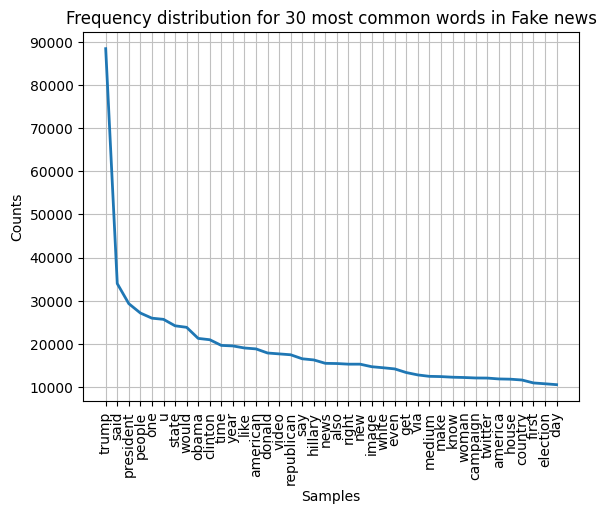

In [57]:
fake_cleaned = text_cleaned(fake_df['combined_text'])
fake_text = join_text(fake_cleaned)
fdist_fake = FreqDist(fake_text)
fdist_fake.plot(40,title='Frequency distribution for 30 most common words in Fake news')

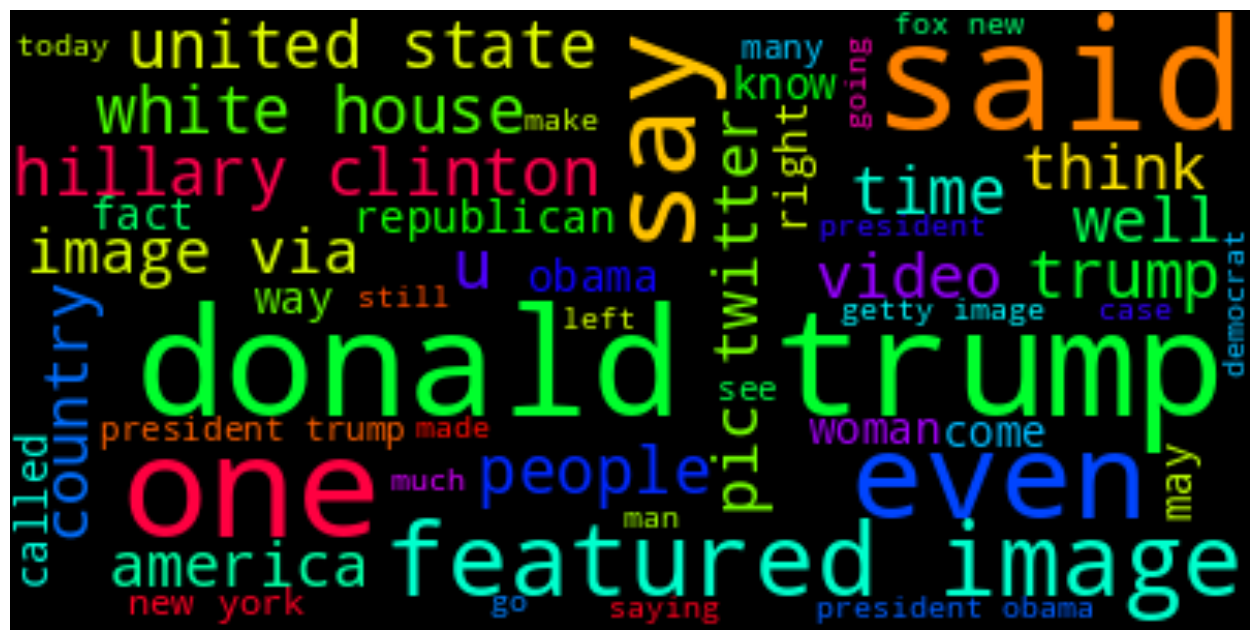

In [59]:
fake_text = ' '.join([word for word in fake_text if word.isalnum()])
#Making wordcloud
wordcloud_faketitle= WordCloud(max_font_size=50,max_words=50,colormap="hsv").generate(fake_text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud_faketitle,interpolation='bilinear')
plt.axis("off")
plt.show()

### Bivariate analysis
Explore relationship between different variables such as relationship between subject and article type

In [61]:
fake_df.groupby(['subject'])['label'].count()

,label
subject,
Government News,1570
Middle-east,778
News,9050
US_News,783
left-news,4459
politics,6838


Check frequent words in politic fake news

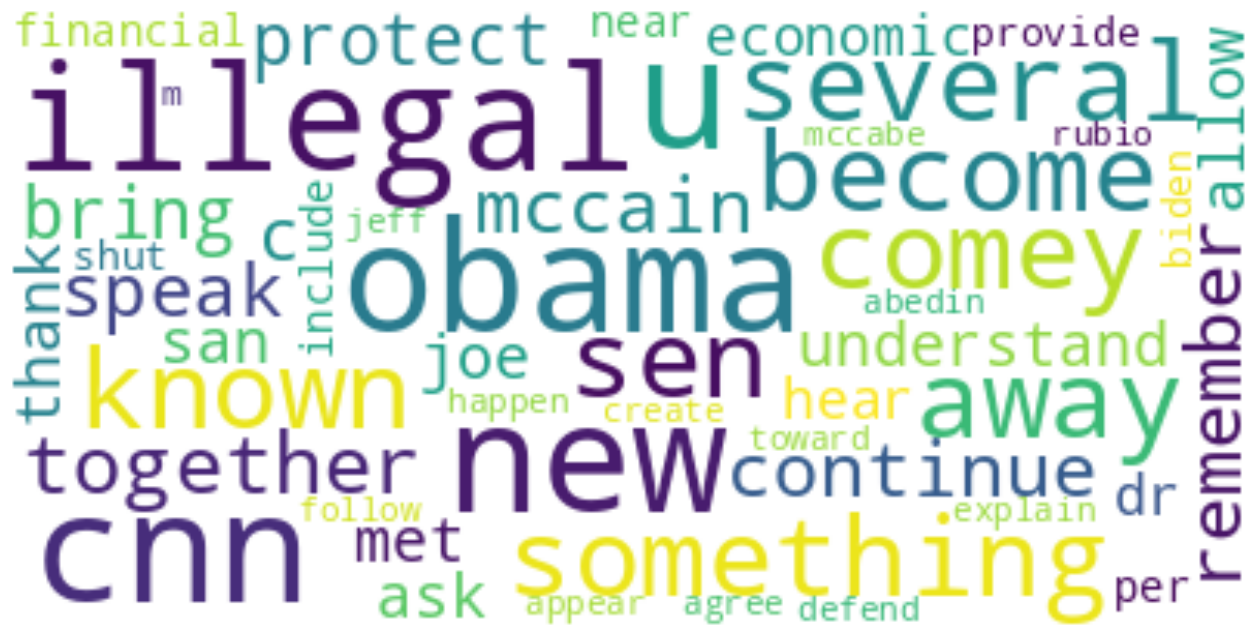

In [63]:
politic_fakedf = fake_df.loc[fake_df["subject"]=='politics','text']
fdist_pfake = FreqDist(join_text(text_cleaned(politic_fakedf)))
pfake_wordcloud = ' '.join([word for word in fdist_pfake if word.isalnum()])
#Making wordcloud
wordcloud_faketitle= WordCloud(max_font_size=50,max_words=50,background_color="white").generate(pfake_wordcloud)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud_faketitle,interpolation='bilinear')
plt.axis("off")
plt.show()

## Real news dataset

In [48]:
print(true_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 21211 entries, 10142 to 17711
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            21211 non-null  object 
 1   text             21211 non-null  object 
 2   subject          21211 non-null  object 
 3   label            21211 non-null  object 
 4   combined_text    21211 non-null  object 
 5   url_count        21211 non-null  int64  
 6   pronoun_counts   21211 non-null  int64  
 7   spe_char_count   21211 non-null  int64  
 8   cleaned_text     21211 non-null  object 
 9   sentiment_score  21211 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 1.8+ MB
None


### Average word counts in Real News Title

In [44]:
true_title_count = count_word(true_df['title'])
ttitle_mean = np.mean(true_title_count)
print('Average word count for true news title',int(ttitle_mean))

Average word count for true news title 64


In [41]:
ttitle_mode = stats.mode(true_title_count)
print(ttitle_mode,'for true news titles')

ModeResult(mode=np.int64(64), count=np.int64(1119)) for true news titles


According to the mode result , we can see that the most common real news title length is 89 words and 551 titles have exactly 89 words.

### Lexical richness of the text

In [ ]:
tjoin = ''.join(true_df['combined_text'])
t_unique_words = set(tjoin.split(' '))
print('total words:',len(tjoin))
print('unique words',len(t_unique_words))
tpercent = (len(t_unique_words) / len(tjoin))*100
print("The number of distinct words is {} % of the total number of words".format(round(tpercent,2)))
print("each word is used {} times on average".format(int(len(tjoin)/len(t_unique_words))))

### Most common words in Real news dataset

<Axes: title={'center': 'Frequency distribution for 30 most common words in Real news'}, xlabel='Samples', ylabel='Counts'>

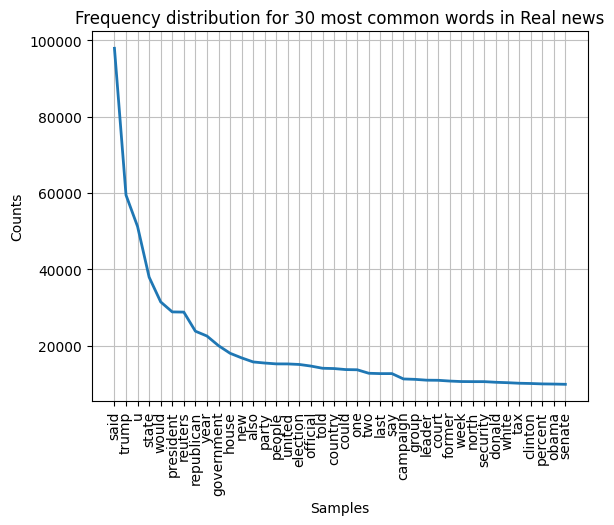

In [58]:
true_cleaned = text_cleaned(true_df['combined_text'])
true_text = join_text(true_cleaned)
tdist_true = FreqDist(true_text)
tdist_true.plot(40,title='Frequency distribution for 30 most common words in Real news')

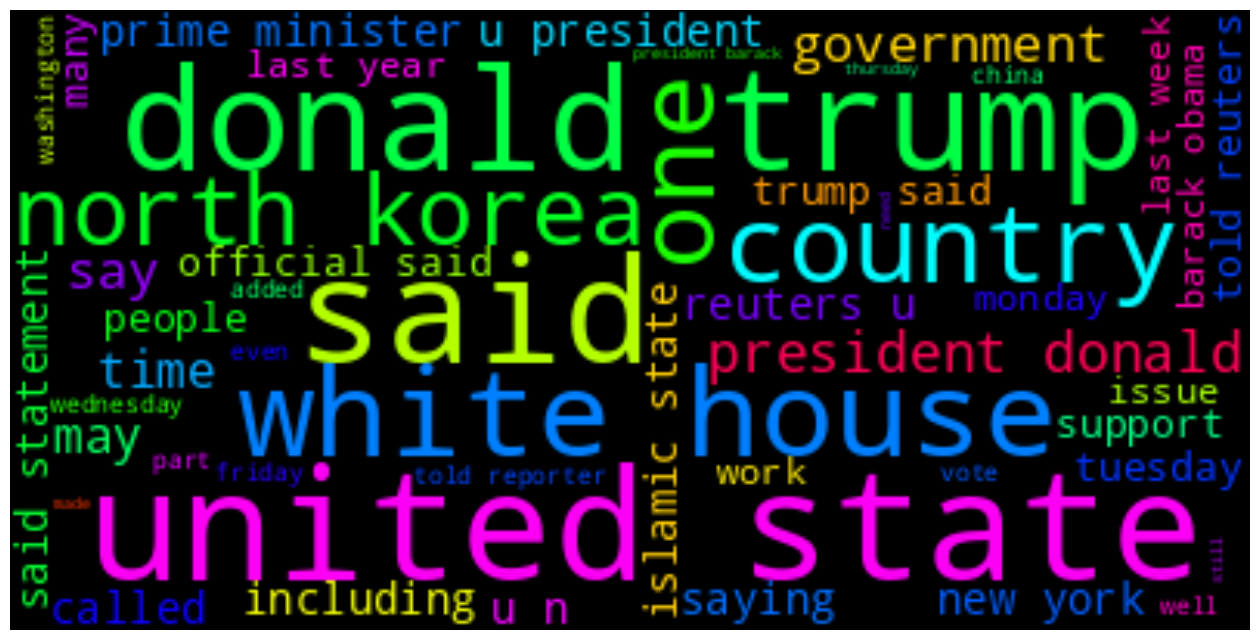

In [60]:
true_text = ' '.join([word for word in true_text if word.isalnum()])
#Making wordcloud
wordcloud_truetitle= WordCloud(max_font_size=50,max_words=50,colormap="hsv").generate(true_text)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud_truetitle,interpolation='bilinear')
plt.axis("off")
plt.show()

### Bivariate analysis

Explore relationship between different variables such as relationship between subject and article type

In [62]:
true_df.groupby(['subject'])['label'].count()

,label
subject,
politicsNews,11220
worldnews,9991


### Check frequent words in Real news

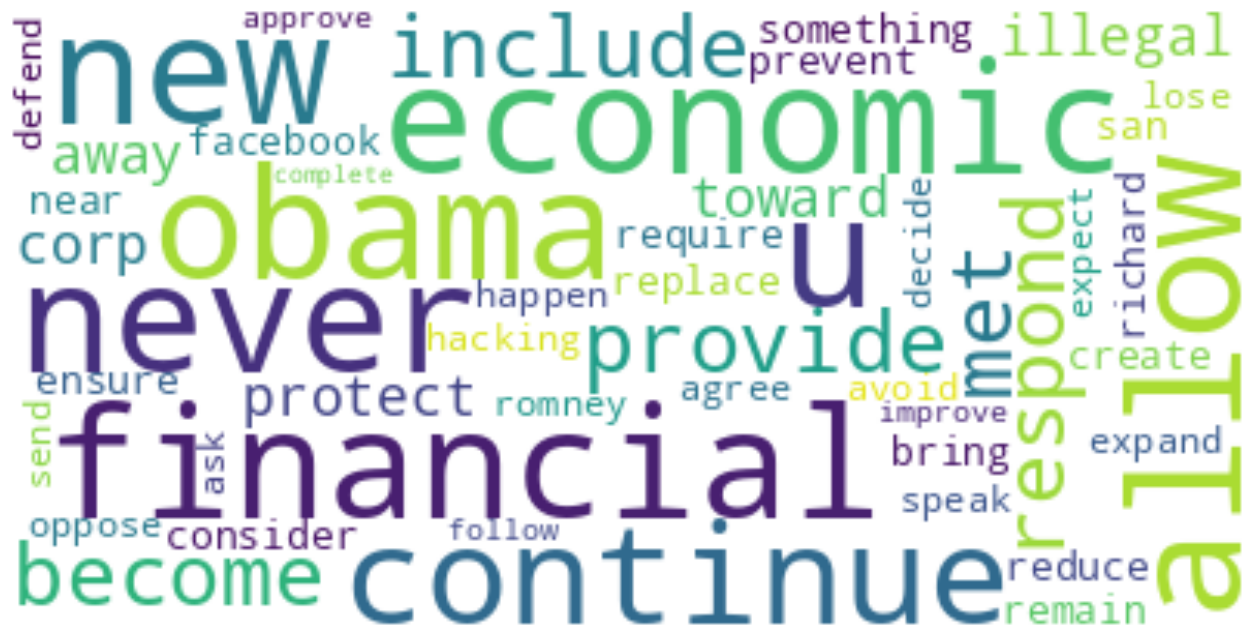

In [64]:
politic_truedf = true_df.loc[true_df["subject"]=='politicsNews','text']
fdist_ptrue = FreqDist(join_text(text_cleaned(politic_truedf)))
ptrue_wordcloud = ' '.join([word for word in fdist_ptrue if word.isalnum()])
#Making wordcloud
wordcloud_truetitle= WordCloud(max_font_size=50,max_words=50,background_color="white").generate(ptrue_wordcloud)
plt.figure(figsize=(16,12))
plt.imshow(wordcloud_truetitle,interpolation='bilinear')
plt.axis("off")
plt.show()

## Training the models

In [ ]:
# Assuming df contains all the necessary data including 'cleaned_text' for TF-IDF and selected features like 'url_count'

# Step 1: Prepare the data
selected_features = ['url_count', 'pronoun_counts', 'sentiment_score', 'spe_char_count']

# Split the data into X (features) and y (labels)
X = df[selected_features]  # Specific features



label_encoder = LabelEncoder()
df['encode_label']=label_encoder.fit_transform(df['label'])
y = df['encode_label']  # Assuming target is the label

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['cleaned_text']).toarray()

# For training the custom features and tf-idf

In [ ]:
X_combined = np.hstack([tfidf_matrix,X])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)
val_size=X_test.shape[0]

(X_train, X_val,
 y_train, y_val) = train_test_split(X_train,y_train,test_size=val_size,
                                     stratify=y_train,shuffle=True, random_state=42)


# For training the tf-idf features

In [ ]:
# Split the data into training and testing sets
Xt_train, Xt_test, yt_train, yt_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)
val_size=Xt_test.shape[0]

(Xt_train, Xt_val,
 yt_train, yt_val) = train_test_split(Xt_train,yt_train,test_size=val_size,
                                     stratify=yt_train,shuffle=True, random_state=42)

# For training the custom features

In [ ]:
# Split the data into training and testing sets
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y, test_size=0.2, random_state=42)
val_size=Xc_test.shape[0]

(Xc_train, Xc_val,
 yc_train, yc_val) = train_test_split(Xc_train,yc_train,test_size=val_size,
                                     stratify=yc_train,shuffle=True, random_state=42)

In [ ]:
def gridSearch(model,X_train,y_train,parameters):
    grid_search = GridSearchCV(model, parameters, n_jobs=-1, cv=5, scoring='accuracy', verbose=0)
    grid_search_result = grid_search.fit(X_train,y_train)
    return grid_search_result

In [ ]:
def randomSearch(model,X_train,y_train,parameters):
    random_search = RandomizedSearchCV(model, param_distributions=parameters, n_iter=10, cv=5, scoring='accuracy', verbose=0, random_state=42)
    random_search_result = random_search.fit(X_train,y_train)
    return random_search_result

# Logistic Regression

In [ ]:
lr = LogisticRegression()
parameters = {
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga']  # Solvers that support L1 and L2 penalties
}
best_lr = gridSearch(lr,X_train,y_train,parameters)
lr_model= best_lr.best_estimator_

In [ ]:
lr_custom = LogisticRegression(penalty="l1",solver='liblinear')
lr_custom.fit(Xc_train,yc_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
lr_tfidf = LogisticRegression(penalty="l1",solver='liblinear')
lr_tfidf.fit(Xt_train,yt_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
print('best logistic regression model :',best_lr.best_estimator_)
print("Best training score : ",best_lr.best_score_)
print("Best Hyperparameters :",best_lr.best_params_)
print(f'Mean test scores : {best_lr.cv_results_["mean_test_score"]}')

best logistic regression model : LogisticRegression(penalty='l1', solver='liblinear')
Best training score :  0.992876613301398
Best Hyperparameters : {'penalty': 'l1', 'solver': 'liblinear'}
Mean test scores : [0.99287661 0.72457342 0.98224746 0.72621442]


In [ ]:
y_pred_lr = lr_model.predict(X_val)
accuracy_lr = accuracy_score(y_val,y_pred_lr)
f1_lr = f1_score(y_val,y_pred_lr)
precision_lr = precision_score(y_val,y_pred_lr)
recall_lr = recall_score(y_val,y_pred_lr)
print(f"Accuracy: {accuracy_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")

Accuracy: 0.9931
F1 Score: 0.9927
Precision: 0.9902
Recall: 0.9953


# Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt_parameters = {
   'criterion': ['gini', 'entropy'],  # Splitting criterion
    'max_depth': range(3,10) # Maximum depth of tree

}

best_dt = randomSearch(dt,X_train,y_train,dt_parameters)
dt_model= best_dt.best_estimator_

In [ ]:
print('best decision tree model :',best_dt.best_estimator_)
print("Best training score : ",best_dt.best_score_)
print("Best Hyperparameters :",best_dt.best_params_)
print(f'Mean test scores : {best_lr.cv_results_["mean_test_score"]}')

best decision tree model : DecisionTreeClassifier(max_depth=8)
Best training score :  0.9951143477387265
Best Hyperparameters : {'max_depth': 8, 'criterion': 'gini'}
Mean test scores : [0.99306308 0.71968807 0.9828815  0.72069503]


In [ ]:
y_pred_dt = dt_model.predict(X_val)
accuracy_dt = accuracy_score(y_val,y_pred_dt)
f1_dt = f1_score(y_val,y_pred_dt)
precision_dt = precision_score(y_val,y_pred_dt)
recall_dt = recall_score(y_val,y_pred_dt)
print(f"Accuracy: {accuracy_dt:.4f}")
print(f"F1 Score: {f1_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall: {recall_dt:.4f}")

Accuracy: 0.9951
F1 Score: 0.9948
Precision: 0.9920
Recall: 0.9976


# Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
rf_parameters = {
    'max_depth': range(3,10),  # Tree depth
    'min_samples_split': [2, 5],  # Minimum samples to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
    'bootstrap': [True, False]  # Bootstrapping for sampling
}

best_rf = randomSearch(rf,X_train,y_train,rf_parameters)
rf_model= best_rf.best_estimator_

In [ ]:
print('best random forest model :',best_rf.best_estimator_)
print("Best training score : ",best_rf.best_score_)
print("Best Hyperparameters :",best_rf.best_params_)
print(f'Mean test scores : {best_rf.cv_results_["mean_test_score"]}')

best random forest model : RandomForestClassifier(bootstrap=False, max_depth=8, min_samples_split=5)
Best training score :  0.9831797478447063
Best Hyperparameters : {'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 8, 'bootstrap': False}
Mean test scores : [0.98317975 0.96654658 0.97195392 0.97747383 0.97687769 0.98194909
 0.97154415 0.97545914 0.97542252 0.97918923]


In [ ]:
y_pred_rf = rf_model.predict(X_val)
accuracy_rf = accuracy_score(y_val,y_pred_rf)
f1_rf = f1_score(y_val,y_pred_rf)
precision_rf = precision_score(y_val,y_pred_rf)
recall_rf = recall_score(y_val,y_pred_rf)
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")

Accuracy: 0.9848
F1 Score: 0.9841
Precision: 0.9790
Recall: 0.9892


# Gaussian Naive Bayes Classifier

In [ ]:
nb = GaussianNB()
nb_parameters = {
    'var_smoothing':[1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

best_nb = gridSearch(nb,X_train,y_train,nb_parameters)
nb_model= best_nb.best_estimator_

In [ ]:
print('best naive bayes model :',best_nb.best_estimator_)
print("Best training score : ",best_nb.best_score_)
print("Best Hyperparameters :",best_nb.best_params_)
print(f'Mean test scores : {best_nb.cv_results_["mean_test_score"]}')

best naive bayes model : GaussianNB()
Best training score :  0.9250738844068345
Best Hyperparameters : {'var_smoothing': 1e-09}
Mean test scores : [0.92507388 0.9185471  0.90616506 0.88796475 0.84089796 0.61567144
 0.59344353]


In [ ]:
y_pred_nb = nb_model.predict(X_val)
accuracy_nb = accuracy_score(y_val,y_pred_nb)
f1_nb = f1_score(y_val,y_pred_nb)
precision_nb = precision_score(y_val,y_pred_nb)
recall_nb = recall_score(y_val,y_pred_nb)
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"F1 Score: {f1_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall: {recall_nb:.4f}")

Accuracy: 0.9225
F1 Score: 0.9164
Precision: 0.9392
Recall: 0.8947


# Passive Agressive Classifier

In [ ]:
pa_model = PassiveAggressiveClassifier(random_state=42)
pa_model.fit(X_train,y_train)

PassiveAggressiveClassifier(random_state=42)

In [ ]:
y_pred_pa = pa_model.predict(X_val)
accuracy_pa = accuracy_score(y_val,y_pred_pa)
f1_pa = f1_score(y_val,y_pred_pa)
precision_pa = precision_score(y_val,y_pred_pa)
recall_pa = recall_score(y_val,y_pred_pa)
print(f"Accuracy: {accuracy_pa:.4f}")
print(f"F1 Score: {f1_pa:.4f}")
print(f"Precision: {precision_pa:.4f}")
print(f"Recall: {recall_pa:.4f}")

# Comparison between the models

In [ ]:
# Assuming you have calculated the metrics for each model and stored them in variables like accuracy_lr, f1_lr, etc.

# Create a dictionary to store the results
results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gaussian Naive Bayes', 'Passive Aggressive'],
    'Accuracy': [accuracy_lr, accuracy_dt, accuracy_rf, accuracy_nb, accuracy_pa],
    'F1 Score': [f1_lr, f1_dt, f1_rf, f1_nb, f1_pa],
    'Precision': [precision_lr, precision_dt, precision_rf, precision_nb, precision_pa],
    'Recall': [recall_lr, recall_dt, recall_rf, recall_nb, recall_pa]
}

# Create a pandas DataFrame from the dictionary
results_df = pd.DataFrame(results)

# Display the table
results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,Logistic Regression,0.992504,0.992124,0.990610,0.993643
1,Decision Tree,0.995077,0.994834,0.992039,0.997645
2,Random Forest,0.984784,0.984071,0.979026,0.989169
3,Gaussian Naive Bayes,0.922466,0.916436,0.939199,0.894749
4,Passive Aggressive,0.925822,0.915638,0.996124,0.847186


# Deep learning model

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
Input_Dimension = X_train.shape[1]
Output_Dimension = 1

#implement custom loss function and metrics
Loss_Func = 'binary_crossentropy'
METRICS = ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]

#early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop if val_loss does not improve for 5 epochs
    restore_best_weights=True, # Keep the best model
)


single_hidden = models.Sequential(name='single_layer')
single_hidden.add(layers.Input(shape=(Input_Dimension,)))
single_hidden.add(layers.Dense(64,kernel_regularizer=l2(0.001),activation ='relu', name="hidden_1"))
single_hidden.add(Dropout(0.5))
single_hidden.add(layers.Dense(Output_Dimension, activation="sigmoid", name="output"))

single_hidden.compile(optimizer=RMSprop(learning_rate=0.001),
                 loss=Loss_Func, metrics=METRICS)

singleL_history = single_hidden.fit(X_train, y_train, epochs=150, batch_size=512,
          validation_data=(X_val, y_val), callbacks=[early_stopping],verbose=0)



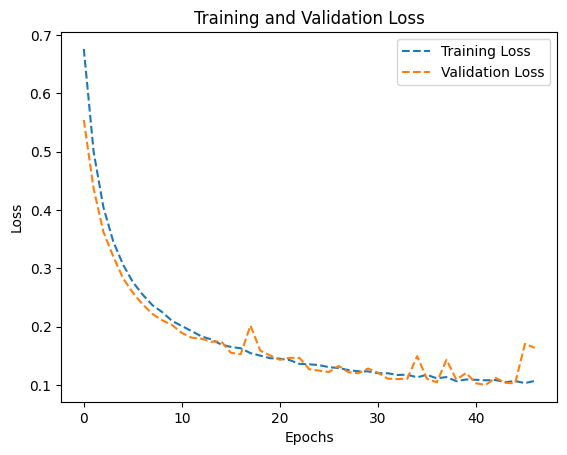

In [ ]:
# plot the training and validation loss
plt.plot(singleL_history.history['loss'],label='Training Loss',linestyle = 'dashed')
plt.plot(singleL_history.history['val_loss'],label='Validation Loss',linestyle = 'dashed')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
singleL_scores = single_hidden.evaluate(X_val, y_val)[1:]
print('--Deep learning model with siingle hidden layer--')
print('Accuracy - Validation : {:.4f}'.format(singleL_scores[0]))
print('Precision - Validation : {:.4f}'.format(singleL_scores[1]))
print('recall - Validation : {:.4f}'.format(singleL_scores[2]))
print('F1 score - Validation : {:.4f}'.format(singleL_scores[3]))

280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9870 - f1_score: 0.6401 - loss: 0.0983 - precision_6: 0.9821 - recall_6: 0.9904
--Deep learning model with siingle hidden layer--
Accuracy - Validation : 0.9860
Precision - Validation : 0.9802
recall - Validation : 0.9906
F1 score - Validation : 0.6447


# Double layer

In [ ]:
double_hidden = models.Sequential(name='single_layer')
double_hidden.add(layers.Input(shape=(Input_Dimension,)))
double_hidden.add(layers.Dense(64,kernel_regularizer=l2(0.001),activation ='relu', name="hidden_1"))
double_hidden.add(Dropout(0.5))
double_hidden.add(layers.Dense(32,kernel_regularizer=l2(0.001),activation ='relu', name="hidden_2"))
double_hidden.add(Dropout(0.5))
double_hidden.add(layers.Dense(Output_Dimension, activation="sigmoid", name="output"))

double_hidden.compile(optimizer=RMSprop(learning_rate=0.001),
                 loss=Loss_Func, metrics=METRICS)

doubleL_history = double_hidden.fit(X_train, y_train, epochs=150, batch_size=512,
          validation_data=(X_val, y_val), callbacks=[early_stopping],verbose=0)


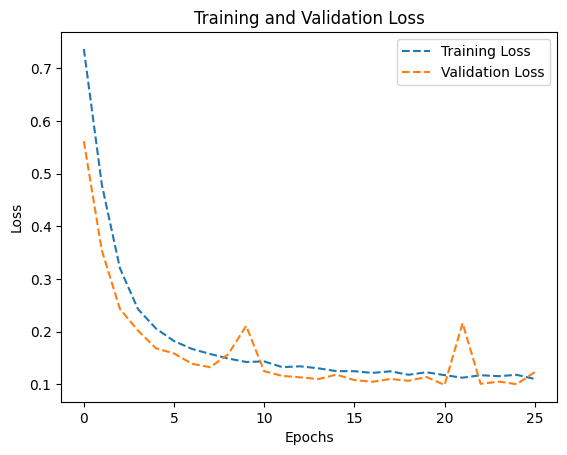

In [ ]:
# plot the training and validation loss
plt.plot(doubleL_history.history['loss'],label='Training Loss',linestyle = 'dashed')
plt.plot(doubleL_history.history['val_loss'],label='Validation Loss',linestyle = 'dashed')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
doubleL_scores = double_hidden.evaluate(X_val, y_val)[1:]
print('--Deep learning model with siingle hidden layer--')
print('Accuracy - Validation : {:.4f}'.format(doubleL_scores[0]))
print('Precision - Validation : {:.4f}'.format(doubleL_scores[1]))
print('recall - Validation : {:.4f}'.format(doubleL_scores[2]))
print('F1 score - Validation : {:.4f}'.format(doubleL_scores[3]))

280/280 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9900 - f1_score: 0.6405 - loss: 0.0970 - precision_6: 0.9914 - recall_6: 0.9874
--Deep learning model with siingle hidden layer--
Accuracy - Validation : 0.9895
Precision - Validation : 0.9892
recall - Validation : 0.9887
F1 score - Validation : 0.6451


In [ ]:
triple_hidden = models.Sequential(name='single_layer')
triple_hidden.add(layers.Input(shape=(Input_Dimension,)))
triple_hidden.add(layers.Dense(128,kernel_regularizer=l2(0.001),activation ='relu', name="hidden_1"))
triple_hidden.add(Dropout(0.5))
triple_hidden.add(layers.Dense(64,kernel_regularizer=l2(0.001),activation ='relu', name="hidden_2"))
triple_hidden.add(Dropout(0.5))
triple_hidden.add(layers.Dense(32,kernel_regularizer=l2(0.001),activation ='relu', name="hidden_3"))
triple_hidden.add(Dropout(0.5))
triple_hidden.add(layers.Dense(Output_Dimension, activation="sigmoid", name="output"))

triple_hidden.compile(optimizer=RMSprop(learning_rate=0.001),
                 loss=Loss_Func, metrics=METRICS)

tripleL_history = triple_hidden.fit(X_train, y_train, epochs=150, batch_size=512,
          validation_data=(X_val, y_val), callbacks=[early_stopping],verbose=0)


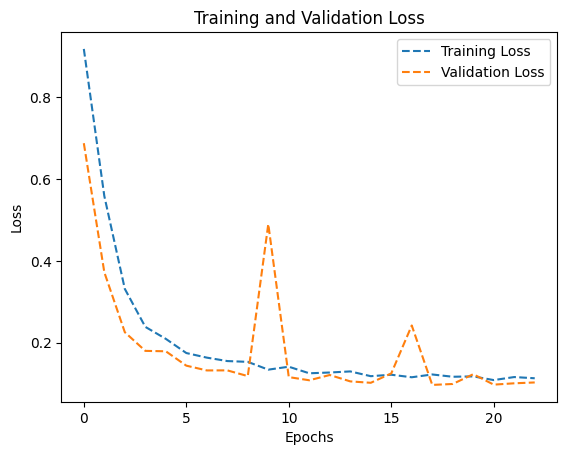

In [ ]:
# plot the training and validation loss
plt.plot(tripleL_history.history['loss'],label='Training Loss',linestyle = 'dashed')
plt.plot(tripleL_history.history['val_loss'],label='Validation Loss',linestyle = 'dashed')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
tripleL_scores = triple_hidden.evaluate(X_val, y_val)[1:]
print('--Deep learning model with siingle hidden layer--')
print('Accuracy - Validation : {:.4f}'.format(tripleL_scores[0]))
print('Precision - Validation : {:.4f}'.format(tripleL_scores[1]))
print('recall - Validation : {:.4f}'.format(tripleL_scores[2]))
print('F1 score - Validation : {:.4f}'.format(tripleL_scores[3]))

280/280 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9898 - f1_score: 0.6412 - loss: 0.0950 - precision_6: 0.9918 - recall_6: 0.9866
--Deep learning model with siingle hidden layer--
Accuracy - Validation : 0.9894
Precision - Validation : 0.9894
recall - Validation : 0.9882
F1 score - Validation : 0.6458


In [ ]:
# Assuming you have calculated the metrics for each model

# Create a dictionary to store the results
dl_results = {
    'Model': ['1 hidden layer model', '2 hidden layers model', '3 hidden layers model'],
    'Accuracy': [singleL_scores[0], doubleL_scores[0], tripleL_scores[0]],
    'F1 Score': [singleL_scores[3], doubleL_scores[3], tripleL_scores[3]],
    'Precision': [singleL_scores[1], doubleL_scores[1], tripleL_scores[1]],
    'Recall': [singleL_scores[2], doubleL_scores[2], tripleL_scores[2]]
}

# Create a pandas DataFrame from the dictionary
dl_results_df = pd.DataFrame(dl_results)

# Display the table
dl_results_df

,Model,Accuracy,F1 Score,Precision,Recall
0,1 hidden layer model,0.986015,0.644657,0.980196,0.990582
1,2 hidden layers model,0.989483,0.645098,0.989164,0.988698
2,3 hidden layers model,0.989371,0.645833,0.989392,0.988227


In [ ]:
 ml_df=results_df.transpose()
 ml_df

,0,1,2,3,4
Model,Logistic Regression,Decision Tree,Random Forest,Gaussian Naive Bayes,Passive Aggressive
Accuracy,0.992504,0.995077,0.984784,0.922466,0.925822
F1 Score,0.992124,0.994834,0.984071,0.916436,0.915638
Precision,0.99061,0.992039,0.979026,0.939199,0.996124
Recall,0.993643,0.997645,0.989169,0.894749,0.847186


In [ ]:
dl_df = dl_results_df.transpose()
dl_df

,0,1,2
Model,1 hidden layer model,2 hidden layers model,3 hidden layers model
Accuracy,0.986015,0.989483,0.989371
F1 Score,0.644657,0.645098,0.645833
Precision,0.980196,0.989164,0.989392
Recall,0.990582,0.988698,0.988227


In [ ]:
compare_df = pd.concat([ml_df,dl_df],axis=1)
compare_df

,0,1,2,3,4,0,1,2
Model,Logistic Regression,Decision Tree,Random Forest,Gaussian Naive Bayes,Passive Aggressive,1 hidden layer model,2 hidden layers model,3 hidden layers model
Accuracy,0.992504,0.995077,0.984784,0.922466,0.925822,0.986015,0.989483,0.989371
F1 Score,0.992124,0.994834,0.984071,0.916436,0.915638,0.644657,0.645098,0.645833
Precision,0.99061,0.992039,0.979026,0.939199,0.996124,0.980196,0.989164,0.989392
Recall,0.993643,0.997645,0.989169,0.894749,0.847186,0.990582,0.988698,0.988227


# Evaluate with test data

In [ ]:
final_y_pred = lr_model.predict(X_test)
final_accuracy = accuracy_score(y_test,final_y_pred)
final_f1_score = f1_score(y_test,final_y_pred)
final_precision = precision_score(y_test,final_y_pred)
final_recall = recall_score(y_test,final_y_pred)
print("--Evaluate logistic regression model with test data--")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1 Score: {final_f1_score:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")

--Evaluate logistic regression model with test data--
Accuracy: 0.9937
F1 Score: 0.9934
Precision: 0.9918
Recall: 0.9950


# Test with real data

In [ ]:
#combine model
pickle.dump(lr_model,open("model.pkl","wb"))
pickle.dump(tfidf,open("tfidf.pkl","wb"))

In [ ]:
#custom features
pickle.dump(lr_custom,open("custom_model.pkl","wb"))


In [ ]:
#tf-idf features
pickle.dump(lr_tfidf,open("lr_tfidf_model.pkl","wb"))

# Plot shap for particular text

In [ ]:
review2="The following statementsÂ were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.Â Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) "
test_model = pickle.load(open('lr_tfidf_model.pkl','rb'))
test_vect = pickle.load(open('tfidf.pkl','rb'))
# Transform text into TF-IDF feature vector
vect_text2 = test_vect.transform([review2])

# Convert NumPy array to Pandas DataFrame
feature_names = test_vect.get_feature_names_out()  # Get feature names
df_vect_text2 = pd.DataFrame(vect_text2.toarray(), columns=feature_names)

print(test_model.predict(vect_text2))

[1]


In [ ]:
review2="Strong winds, dense forest, and unusually dry weather—that's the deadly combination that experts say is fueling the largest wildfires in South Korea's history. The inferno in the southeast has burned through 35,810 hectares (88,500 acres) as of Thursday—about half the size of New York City—killing 27 people so far and displacing tens of thousands.Authorities believe the wildfires started by accident due to human activity, but the main drivers of the devastation are dry land and strong gusts sweeping over inland regions. The high concentration of pine forest in North Gyeongsang province, where the fires are burning, is also oiling the blaze, said a forest disaster expert."


In [ ]:
def find_urls(text):
  url_pattern= re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  urls = re.findall(url_pattern,text)
  if len(urls)==0:
    return 0
  else:
    return urls

print(find_urls(review2))

0


In [ ]:
def find_pronoun(text):
  pronoun_pattern = re.compile(r'\b(I|me|My|my|you|You|he|He|him|she|She|her|it|It|we|We|us|they|They|them)\b')
  pronouns = re.findall(pronoun_pattern,text)
  if len(pronouns)==0:
    return 0
  else:
    return len(pronouns)

print(find_pronoun(review2))

0


In [ ]:
def spec_count(text):
  spec=text.count('@!?') if text.count('@!?')>0 else 0
  return spec

print(spec_count(review2))

0


In [ ]:
analyzer = SentimentIntensityAnalyzer()
def get_compound_score(text):
       scores = analyzer.polarity_scores(text)
       compound_score = scores['compound']
       return compound_score

print(get_compound_score(review2))

-0.7003


In [ ]:
data3 = {'url_count': [find_urls(review2)], 'pronoun_counts': [find_pronoun(review2)],'sentiment_score': [get_compound_score(review2)],'spe_char_count': [spec_count(review2)]}
test_df3 = pd.DataFrame(data3)
test_df3

,url_count,pronoun_counts,sentiment_score,spe_char_count
0,0,0,-0.7003,0


## Plot shap for train dataset

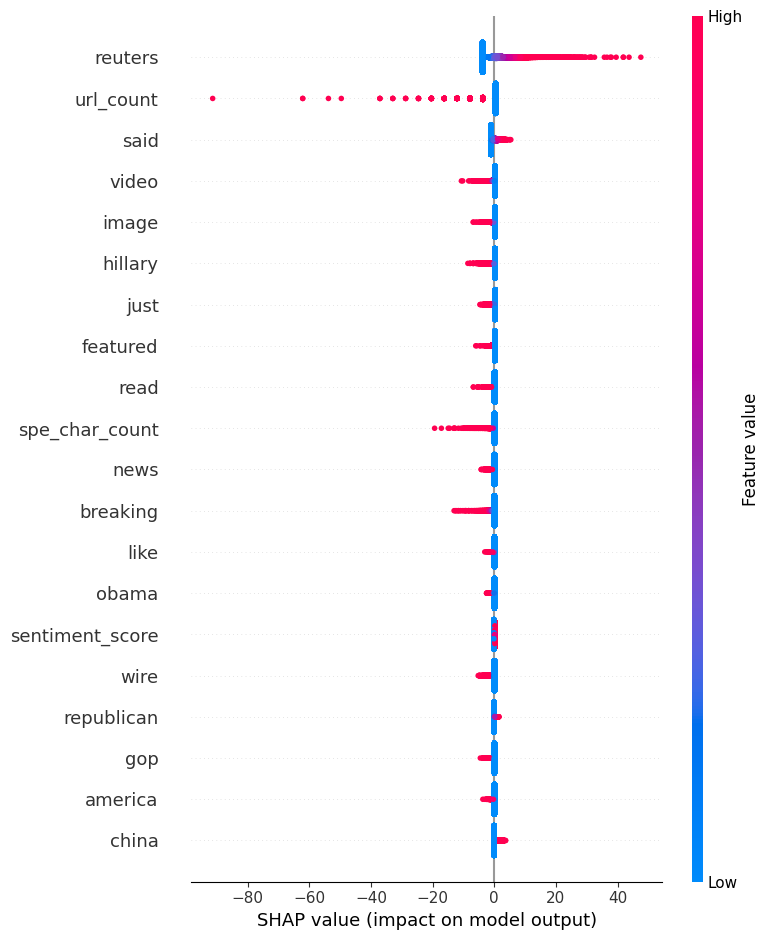

In [ ]:
# Step 5: SHAP for interpreting the combined model
explainer_combined = shap.Explainer(lr_model, X_train)
shap_values_combined = explainer_combined(X_train)

# Step 6: Visualize SHAP values for the combined model (including both feature sets)
shap.summary_plot(shap_values_combined, X_train, feature_names=np.concatenate([tfidf.get_feature_names_out(), selected_features]))

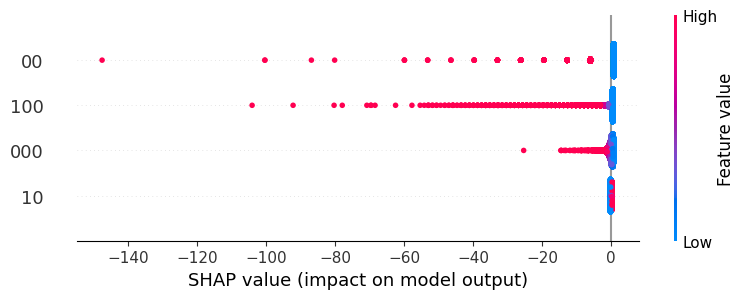

In [ ]:
selected_features = ['url_count', 'pronoun_counts', 'sentiment_score', 'spe_char_count']


# Step 5: SHAP for interpreting the combined model
explainer_custom = shap.Explainer(lr_custom, Xc_train)
shap_values_custom = explainer_custom(Xc_train)

# Step 6: Visualize SHAP values for the combined model (including both feature sets)
shap.summary_plot(shap_values_custom, Xc_train, feature_names=np.concatenate([tfidf.get_feature_names_out(), selected_features]))


Example code for plot shap

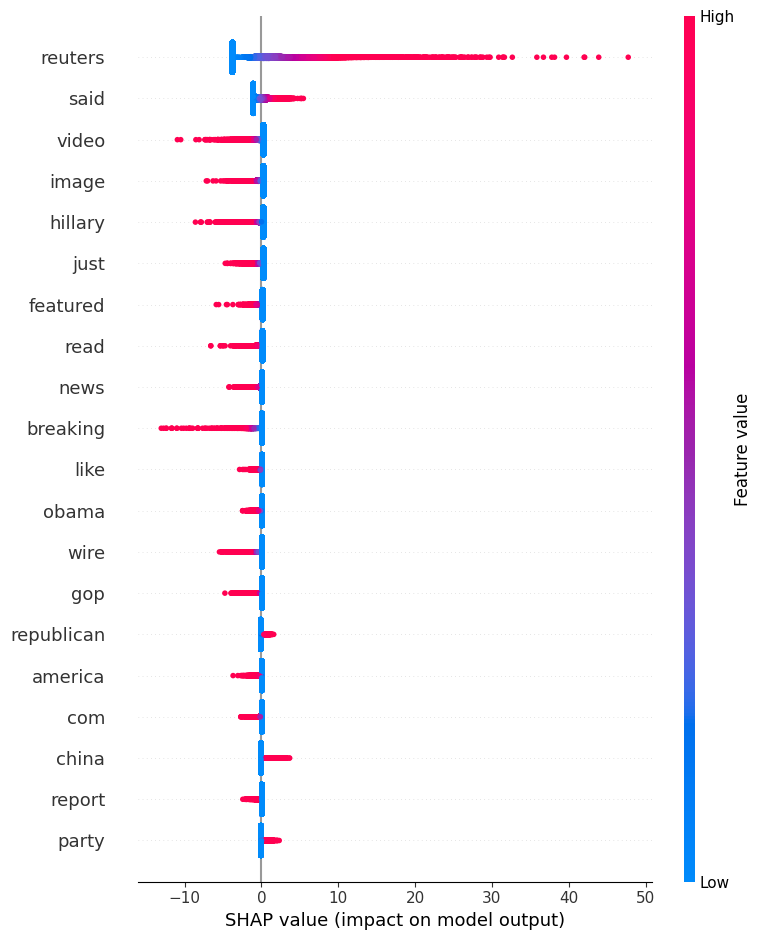

In [ ]:


# Step 5: SHAP for interpreting the combined model
explainer_tfidf = shap.Explainer(lr_tfidf, Xt_train)
shap_values_tfidf = explainer_tfidf(Xt_train)

# Step 6: Visualize SHAP values for the combined model (including both feature sets)
shap.summary_plot(shap_values_tfidf, Xt_train, feature_names=np.concatenate([tfidf.get_feature_names_out(), selected_features]))


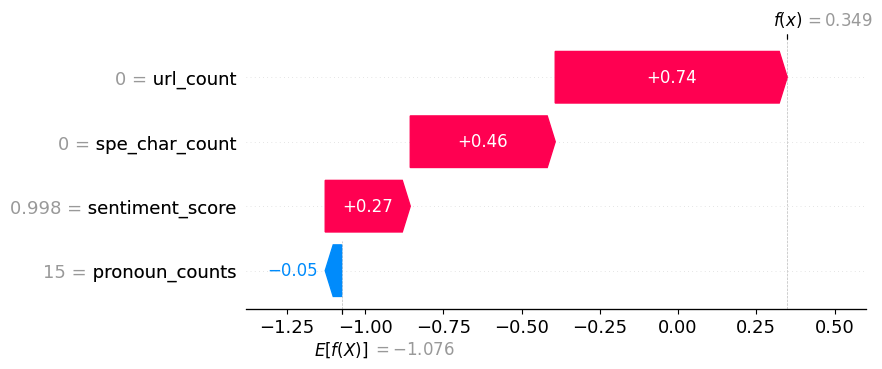

In [ ]:
shap.waterfall_plot(shap_values_custom[0])

In [ ]:
shap.initjs()
shap.force_plot(shap_values_custom[0], Xc_train.iloc[0])

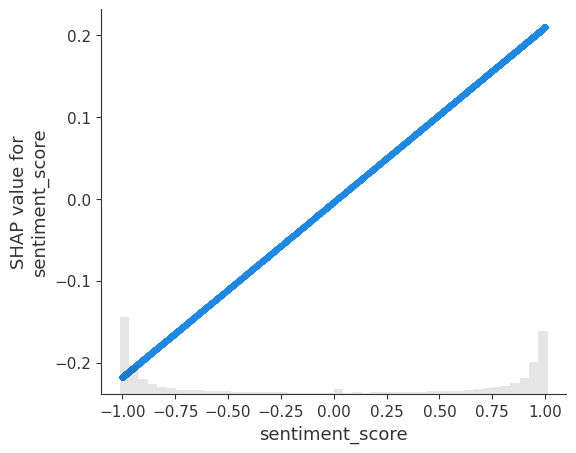

In [ ]:
shap.plots.scatter(shap_values_custom[:, "sentiment_score"])

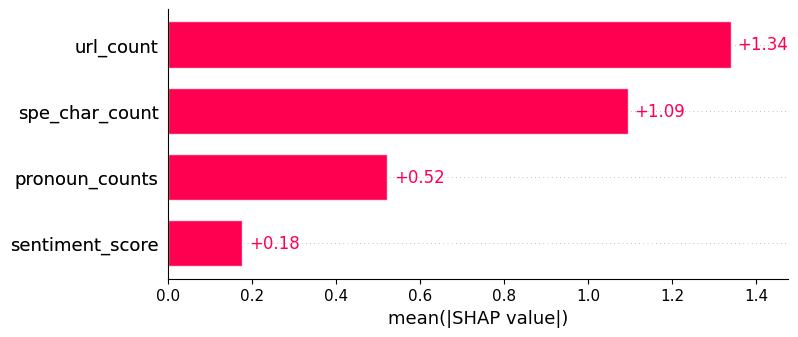

In [ ]:
shap.plots.bar(shap_values_custom)